<a href="https://colab.research.google.com/github/dmartmillan/DeepLearningSpotNuclei/blob/main/template_final3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from PIL import Image
from IPython.display import Image as DPImage
import os
import numpy as np
from random import sample
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn as sk
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import random
import csv
import skimage

from sklearn.model_selection import train_test_split


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, SpatialDropout2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, UpSampling2D
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import ResNet50
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import Input
import keras.backend as K
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.insert(0,'/content/gdrive/My Drive/Colab Notebooks')
data_loc = '/content/gdrive/My Drive/data'
# data_loc = './data'
from data_processing import data_grinder

seed = 2023
np.random.seed(seed)  

Mounted at /content/gdrive


## 0. Some functions

In [2]:
def plot_history(history, steps_per_epoch = 0, y_axis_lower_bound = -1):
    
    if steps_per_epoch >0:
        xvals = int(steps_per_epoch)*np.array(history.epoch)
        xlab = 'Weight update steps'
    else:
        xvals = np.array(history.epoch)
        xlab = 'Epochs'


    plt.figure(figsize = (12,4))
    plt.subplot(1,2,1)
    plt.xlabel(xlab)
    plt.ylabel('Accuracy')
    plt.plot(xvals, np.array(history.history['mean_iou']),'g-', 
             label='Train IoU')
    plt.plot(xvals, np.array(history.history['val_mean_iou']),'r-',
             label = 'Validation IoU')
    if y_axis_lower_bound>-1:
        plt.ylim([y_axis_lower_bound,1])
    plt.legend()

    plt.subplot(1,2,2)
    plt.xlabel(xlab)
    plt.ylabel('Loss minimised by model')
    plt.plot(xvals, np.array(history.history['loss']),'g-', 
             label='Train loss')
    plt.plot(xvals, np.array(history.history['val_loss']),'r-',
             label = 'Validation loss')
    plt.legend()

def iou(y_true, y_pred):
        y_true = tf.cast(y_true, y_pred.dtype)
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
        iou = K.mean((intersection + 1) / (union + 1), axis=0)
        return iou
def mean_iou(y_true, y_pred):
    results = []   
    for t in np.arange(0.5, 1, 0.05):
        t_y_pred = tf.cast((y_pred > t), tf.float32)
        pred = iou(y_true, t_y_pred)
        results.append(pred)
        
    return K.mean(K.stack(results), axis=0)

def diceloss(y_true, y_pred, smooth=1e-6):
    
    #flatten label and prediction tensors
        y_true = tf.cast(y_true, y_pred.dtype)
        intersection = K.sum(K.abs(y_true * y_pred))
        dice = (2*intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)
        return 1 - dice

## 1. Load images

In [3]:
import pickle
data_set = open(f'{data_loc}/data_set.obj', 'rb')
data_dict = pickle.load(data_set)
data_set.close()
train_dict = data_dict['train_dict']
val_dict = data_dict['val_dict']
test_dict = data_dict['test_dict']
data_dict.clear()

## 2. Pre-processing

### 2.1 Procedure

In [4]:
train_set = data_grinder(train_dict)
val_set = data_grinder(val_dict)
train_set.preprocessImages()
val_set.preprocessImages()

### 2.2 Displace images

Image, processed image and mask from data set No. 533 with size (360, 360): c8ca945abc29d262a5525e4c2585541bba33fa77c86a47c94575d8e5b54c83fb


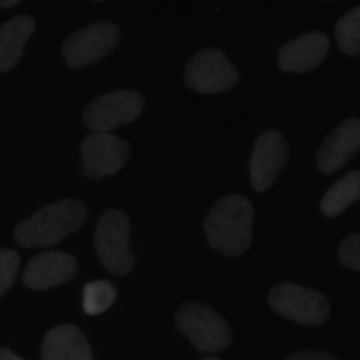

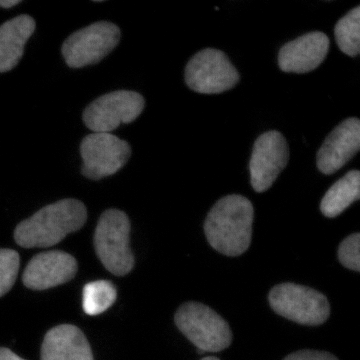

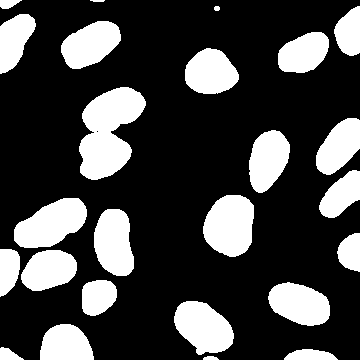

In [5]:
# display
train_set.display_imgs(ix0= 533) # without ix0 input, it will give a random index

## 3. Pre-processing

In [6]:
train_set.croporresizeImages()
val_set.croporresizeImages()

###3.2 Displace images

Processed image and mask from train set No. 73 with size (256, 256): 1c2f9e121fc207efff79d46390df1a740566b683ff56a96d8cabe830a398dd2e


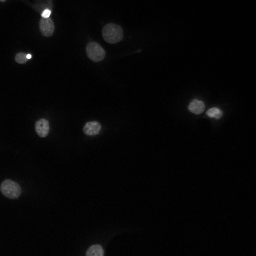

It crops to 4 masks with size (128, 128, 1)
cropped image and mask: 1


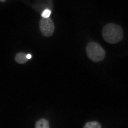

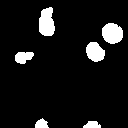

cropped image and mask: 2


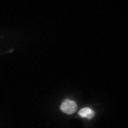

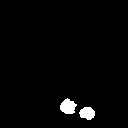

cropped image and mask: 3


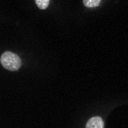

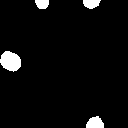

cropped image and mask: 4


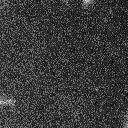

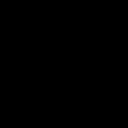

In [7]:
# display
train_set.display_crops() # without ix0 input, it will give a random index

## 4. Test the rejoin function

Image and mask from data set No. 272 with size (696, 520): 61dc249314d7b965eb4561ec739eab9b0f60af55c97b25ced8cb2a42a0be128e
Original image


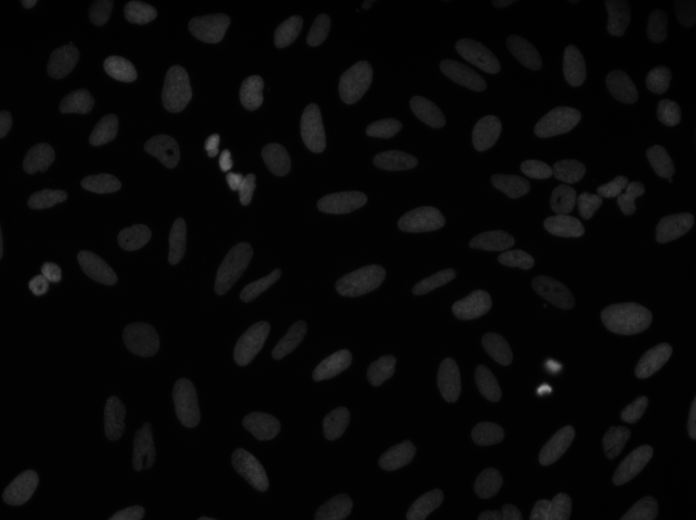

Processed image


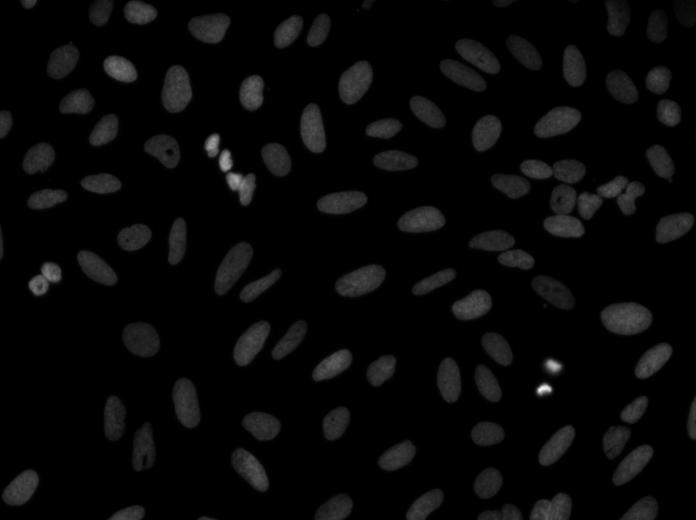

Original mask


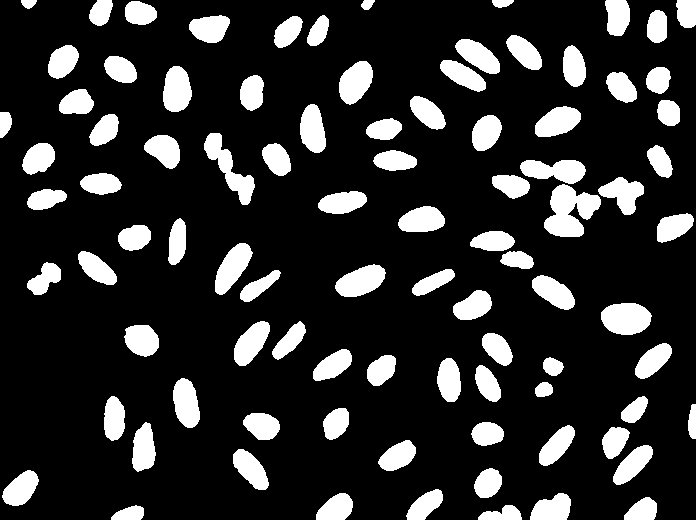

Rejoined mask


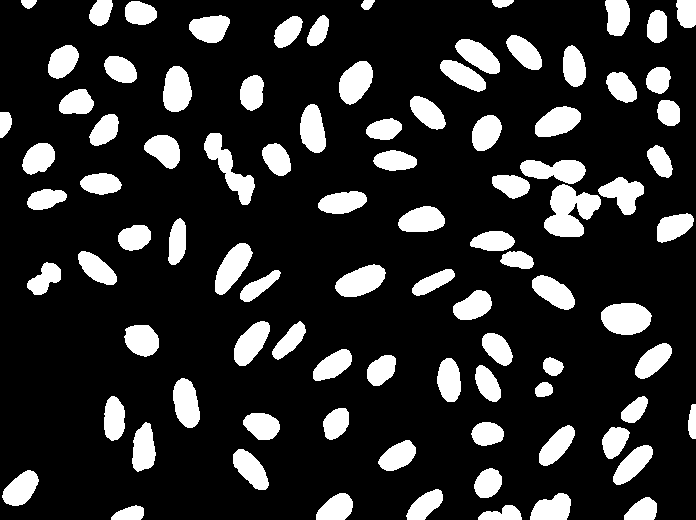

In [8]:
Y_pred_train = train_dict['Y']
train_set.rejoinMask(Y_pred_train)
train_set.display_rejoinmasks() # without ix0 input, it will give a random index

## 5. UNET model

### 5.1 Prepare data

In [23]:
train_set.list2array()
val_set.list2array()
X_train0, Y_train = train_set.data_dict['X_array'], train_set.data_dict['Y_array']
X_val0, Y_val = val_set.data_dict['X_array'], val_set.data_dict['Y_array']

 # gray scale only need one value, cause RGB values are the same. you can include all RGB data as well, but have to change the model input dimension as well.
X_train = tf.keras.applications.efficientnet.preprocess_input(X_train0)
X_val = tf.keras.applications.efficientnet.preprocess_input(X_val0)
print(f'X_train shape: {X_train.shape}; Y_train shape: {Y_train.shape}')
print(f'X_val shape: {X_val.shape}; Y_val shape: {Y_val.shape}')

X_train shape: (7315, 128, 128, 3); Y_train shape: (7315, 128, 128, 1)
X_val shape: (812, 128, 128, 3); Y_val shape: (812, 128, 128, 1)


### 5.2 Model setup

In [24]:
# The convolation block 
def conv_block(m, dim, acti, bn, res, do=0, l2=0, l1=0):
    n = Conv2D(dim, 3, activation=acti, padding='same', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))(m)
    n = BatchNormalization()(n) if bn else n
    n = Dropout(do)(n) if do else n
    n = Conv2D(dim, 3, activation=acti, padding='same', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))(n)
    n = BatchNormalization()(n) if bn else n
    return Concatenate()([m, n]) if res else n



def level_block(transfer_model,layer_name, m, dim, depth, idx, inc, acti, do, l2, l1, bn, mp, up, res):

    if depth > 0:
        if idx == 0:
            n = transfer_model.get_layer(index=0).output
        else:
            n = transfer_model.get_layer(layer_name[idx-1]).output
            print(f"the {idx+1} layer of transfer model is {n.shape}")
        # m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
        m = level_block(transfer_model,layer_name, m, int(inc*dim), depth-1, idx+1, inc, acti, do, l2, l1, bn, mp, up, res)
        if up:
            m = UpSampling2D()(m)
            m = Conv2D(dim, 2, activation=acti, padding='same')(m)
        else:
            m = Conv2DTranspose(dim, 2, strides=2, activation=acti, padding='same')(m)
        n = Concatenate()([n, m])
        m = conv_block(n, dim, acti, bn, res)
    else:
        m = transfer_model.get_layer(layer_name[-1]).output
        print(f"the {idx+1} layer of transfer model is {m.shape}")
    return m

def Transfer_UNet(img_shape, out_ch=1, start_ch=64, depth=4, idx = 0, inc_rate=2., activation='relu', 
         dropout=0.5, l2 = 0, l1 = 0, batchnorm=False, maxpool=True, upconv=True, residual=False):
    i = Input(shape=img_shape)
    transfer_model = tf.keras.applications.EfficientNetB7(input_shape=img_shape, input_tensor=i, include_top=False, weights='imagenet')
    transfer_model.trainable = False
    layer_name = ['block2a_expand_activation', 'block3a_expand_activation', 'block4a_expand_activation', 'block6a_expand_activation']
    o = level_block(transfer_model,layer_name, i, start_ch, depth, idx, inc_rate, activation, dropout, l2, l1, batchnorm, maxpool, upconv, residual)
    o = Conv2D(out_ch, 1, activation='sigmoid')(o)
    model = Model(inputs=i, outputs=o)
    return model, transfer_model

### 5.3 Parameters

In [29]:
epochs = 50
batch_size = 32
LR = 0.0001

stopping_patience=20
stopping_delta=0.001
img_shape = (128,128,3)

early_stopping = EarlyStopping(patience=stopping_patience, min_delta=stopping_delta, monitor= 'val_mean_iou', mode='max',
                               restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

model, transfer_model = Transfer_UNet(img_shape,start_ch=32,depth=4,idx = 0,batchnorm=True, dropout=0, upconv=False)
model.compile(loss=diceloss, optimizer=Adam(learning_rate=LR), metrics=[mean_iou])
model.summary()

the 2 layer of transfer model is (None, 64, 64, 192)
the 3 layer of transfer model is (None, 32, 32, 288)
the 4 layer of transfer model is (None, 16, 16, 480)
the 5 layer of transfer model is (None, 8, 8, 1344)
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_14 (Rescaling)       (None, 128, 128, 3)  0           ['input_8[0][0]']                
                                                                                                  
 normalization_7 (Normalization  (None, 128, 128, 3)  7          ['rescaling_14

### 5.4 Training

In [ ]:
history = model.fit(X_train, Y_train,
                    validation_data=[X_val, Y_val], 
                    epochs=epochs,
                    batch_size=batch_size,
                    # callbacks=[early_stopping],
                    # callbacks=[stopping_callback, model_checkpoint, reduce_lr],
                    shuffle=True)
# i = 1
# while os.path.exists(f'{data_loc}/UNET_{i}'):
#     i += 1
# test_savepath = f'{data_loc}/UNET_{i}'
# model.save(test_savepath)

Epoch 1/50
229/229 [==============================] - 49s 114ms/step - loss: 0.3849 - mean_iou: 0.5826 - val_loss: 0.3145 - val_mean_iou: 0.7045
Epoch 2/50
229/229 [==============================] - 21s 90ms/step - loss: 0.1612 - mean_iou: 0.8079 - val_loss: 0.1828 - val_mean_iou: 0.7528
Epoch 3/50
229/229 [==============================] - 20s 89ms/step - loss: 0.1118 - mean_iou: 0.8449 - val_loss: 0.1703 - val_mean_iou: 0.7651
Epoch 4/50
229/229 [==============================] - 20s 89ms/step - loss: 0.0904 - mean_iou: 0.8604 - val_loss: 0.1835 - val_mean_iou: 0.7471
Epoch 5/50
229/229 [==============================] - 21s 90ms/step - loss: 0.0807 - mean_iou: 0.8643 - val_loss: 0.1675 - val_mean_iou: 0.7511
Epoch 6/50
229/229 [==============================] - 20s 89ms/step - loss: 0.0723 - mean_iou: 0.8735 - val_loss: 0.1511 - val_mean_iou: 0.7699
Epoch 7/50
229/229 [==============================] - 20s 89ms/step - loss: 0.0684 - mean_iou: 0.8751 - val_loss: 0.1667 - val_mean_iou

### 5.5 Model evaluation

In [ ]:
[train_loss, train_IoU] = model.evaluate(X_train, Y_train, verbose=0)
print("Training set IoU:{:7.4f}".format(train_IoU))
print("Training set Loss:{:7.6f}\n".format(train_loss))

[val_loss, val_IoU] = model.evaluate(X_val, Y_val, verbose=0)
print("Validation set IoU:{:7.4f}".format(val_IoU))
print("Validation set Loss:{:7.6f}\n".format(val_loss))

plot_history(history)

In [ ]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_val, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [ ]:
ix = random.randint(0, len(preds_val_t))
display(keras.preprocessing.image.array_to_img(X_val0[ix]*255))
display(keras.preprocessing.image.array_to_img(Y_val[ix]))
display(keras.preprocessing.image.array_to_img(preds_val_t[ix]))

### 5.6 Calculate IoU for Validation set

In [ ]:
train_set.rejoinMask(preds_train)
val_set.rejoinMask(preds_val)

train_set.cal_iou()
print("Train set IoU:{:7.4f}".format(train_set.mean_iou))
val_set.cal_iou()
print("Validation set IoU:{:7.4f}".format(val_set.mean_iou))

### 5.7 Test evaluation (to be updated)

In [ ]:
test_set = data_grinder(test_dict)
test_set.preprocessImages()
test_set.croporresizeImages(hasmask = False)
test_set.list2array()
X_test0 = test_set.data_dict['X_array']

X_test = X_test0[:,:,:,:3]/255 # standardization

In [ ]:
preds_test = model.predict(X_test, verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.uint8)
test_set.rejoinMask(preds_test)

In [ ]:
imageIDs = test_set.data_dict['imageIDs']
ix = random.randint(0, len(imageIDs) - 1)
display(test_set.data_dict['images'][ix])
display(test_set.data_dict['cal_masks'][ix])

## 6. Export to EXCEL